In [1]:
# Bibliotecas
# Tabelas
import pandas as pd
# Vetores
import numpy as np
# Progresso
from tqdm import tqdm
# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
# Carregamento de arquivos
from zipfile import ZipFile as zp
# Banco de Dados
import pymongo
# Tempo
from dateutil import parser

# 0. Funções

In [2]:
def listColumnsChar(df, colName):
    """ 
        Função para explorar dados em colunas
    """
    aux = df[colName]
    display(aux.head())
    mask = aux.dtypes == 'O'
    for col in aux.loc[:, mask].columns:
        print(f"{listComposition(col, ''.join([str(x) for x in aux[col].unique().tolist()]))} Ex:{aux.loc[0, col]}")

def listComposition(col, val):
    """ 
        Verifica se um dado campo possui caracteres numéricos, especiais e alfabéticos.
        retorna uma string com três elementos que podem ser zero ou um, 1 quanto existe
        um elemento de um dado tipo e 0 caso contrário.
    """
    aux = np.unique(list(val))
    isCharNumSpec = ['0', '0', '0']
    for ii in aux:
        if ii.isalpha():
            isCharNumSpec[0] = '1'
        elif ii.isnumeric():
            isCharNumSpec[1] = '1'
        else:
            isCharNumSpec[2] = '1'

    return f'{col}: Char-Num-Spec: {"-".join(isCharNumSpec)} Charcters: {aux}'

def subsMonth(val, mDict):
    """
        Substitui o mês por seu equivalente numérico e retrona uma string
        ------
        Parameters:
        val: list
        mDict: dictionary
    """
    val[1] = mDict[val[1]]
    return '-'.join(val)

def fixDateString(serie, mDict):
    """
        Altera a string da coluna, mantendo apenas a data e subistituindo o mês por
        seu equivalente numérico, além de trocar os dados faltantes por None
    """
    serie = serie.apply(lambda x: x.split(' ', -1)[0] if type(x) == str else None)
    serie = serie.apply(lambda x: subsMonth(x.split('-'), mDict) if type(x) == str else None)
    return serie

def mergeTables(db, base, leftCol, rightCol):
    """
        Pesquisa valores em uma tabela e retorna a combinação das da tabela encontrada
        com a passada por parâmetro.
        -----------
        Parameters:
        db: Conexão com o MongoDb
        base: DataFrame que será a base para inserção dos dados encontrados na pesquisa
        leftCol: String que representa o nome da coluna guia da tabela pesquisada no banco
        rightCol: String que representa o nome da coluna guia no DataFrame base.
        -------------
        return: Dataframe combinado
    """
    aux = pd.DataFrame(db.find({leftCol: base[rightCol].values[0]}, {'_id': 0}))

    aux = pd.merge(left=aux, right=base, left_on=leftCol, right_on=rightCol)
    return aux

def retrieveData(cnes, collection, data, partial=True):
    """
        Pesquisa no banco de dados por um valor de CNES e retorna a tabela encontrada
    """
    collectionsList = ['tbEstado202107', 'tbMotivoDesativacao202107', 'tbMunicipio202107', 'tbNaturezaJuridica202107', 'tbTipoEstabelecimento202107', 'tbTipoUnidade202107']
    aux = pd.DataFrame(data[collection].find({'CO_CNES': cnes}, {'_id': 0}))

    if len(aux) >0:

        if partial:
            return aux
        else:
            aux = mergeTables(data[collectionsList[1]], aux, 'CD_MOTIVO_DESAB', 'CO_MOTIVO_DESAB')
            # aux = mergeTables(data[collectionsList[2]], aux, 'CO_MUNICIPIO', 'CO_MUNICIPIO_GESTOR')
            aux = mergeTables(data[collectionsList[3]], aux, 'CO_NATUREZA_JUR', 'CO_NATUREZA_JUR')
            aux = mergeTables(data[collectionsList[4]], aux, 'CO_TIPO_ESTABELECIMENTO', 'CO_TIPO_ESTABELECIMENTO')
            # aux = mergeTables(data[collectionsList[5]], aux, 'CO_TIPO_UNIDADE', 'CO_TIPO_UNIDADE')
        
            return aux
    else:
        return f'Nenhum valor encontrado para CNES:{cnes}'

# 1. Carregar arquivos

Carregar os dados dos **.csv** na memória do sitema. Os dados serão armazenados em um dicionário, onde cada entrada corresponde a uma tabela

In [3]:
# Caminho do arquivo
filePath = 'D:\Ivan\OneDrive\Projetos\Códigos ( Profissional )\Material criado\LAIS\Personal_Proj_Lais_Data_Engineer\Data\ARQUIVOS_EDITAL_43_2021_PERFIL_X_DATA_ENGINEERING.zip'

sourceFile = zp(filePath)                                           # Carrega o arquivo
filesInSource = sourceFile.namelist()                               # Lista arquivos dentro
rawDataDict = {k.split('/', -1)[-1].split('.')[0]: pd.read_csv(sourceFile.open(k), sep=';', na_values=['undefined'], low_memory=False) for k in filesInSource} # Carrega cada tabela e armazena num dicionário
dctKeys = [*rawDataDict]                                            # Salva as keys do dicionário como em uma lista
dctKeys                                                             # Mostra as keys salvas

['tbEstabelecimento202107',
 'tbEstado202107',
 'tbMotivoDesativacao202107',
 'tbMunicipio202107',
 'tbNaturezaJuridica202107',
 'tbTipoEstabelecimento202107',
 'tbTipoUnidade202107']

# 2. Processamento

A ideia do passo a seguir é entender que tipo de dado há em cada coluna, para então verificarmos se há erro nos dados armazenados

In [6]:
listColumnsChar(rawDataDict, dctKeys[1])    # Eplorar dados

,CO_UF,CO_SIGLA,NO_DESCRICAO
0,27,AL,ALAGOAS
1,13,AM,AMAZONAS
2,29,BA,BAHIA
3,23,CE,CEARA
4,50,MS,MATO GROSSO DO SUL


CO_SIGLA: Char-Num-Spec: 1-0-0 Charcters: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'I' 'J' 'L' 'M' 'N' 'O' 'P' 'R' 'S' 'T'] Ex:AL
NO_DESCRICAO: Char-Num-Spec: 1-0-1 Charcters: [' ' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'L' 'M' 'N' 'O' 'P' 'R' 'S'
 'T' 'U' 'Z'] Ex:ALAGOAS


Após verificação dos tipos de dados em todas as tabelas, observei problemas maiores apenas na tabela: **'tbEstabelecimento202107'**. Devido ao grande número de informações faltantes nos campos datetime, decidi por corrigir apenas os campos com dados de longitude e latitude, mantendo padrão a separação dos números ( **.** ), os dados não 'corrigidos' foram inseridos no banco como foram recebidos.

In [7]:
table = rawDataDict[dctKeys[0]]                 # Tabela
dtMask = table.columns.str.contains("DT")       # Listar colunas que começam com DT ( onde os erros foram observados )
display(table.loc[:, dtMask].head())            # Dados antes da alteração

# Correção de datetime
# monthDict = {'jan': '01', 'fev': '02', 'mar': '03', 'abr': '04', 'mai': '05', 'jun': '06', 'jul': '07', 'ago': '08', 'set':'09', 'out':'10', 'nov': '11', 'dez': '12', '00': '00'} 
# cols = ['DT_EXPEDICAO','DT_VAL_LIC_SANI']
# for ii in cols:
#     table[ii] = fixDateString(table[ii], monthDict)
#     table[ii] = pd.to_datetime(table[ii], format='%d-%m-%Y', errors='ignore')

# cols = ["TO_CHAR(DT_ATUALIZACAO,'DD/MM/YYYY')", "TO_CHAR(DT_ATU_GEO,'DD/MM/YYYY')",	"TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')"]
# for ii in cols:
#     table[ii] = table[ii].apply(lambda x: parser.parse(x))#pd.to_datetime(table[ii], format='%d/%m/%Y', errors='ignore')
    
# Padronização de Latitude e Longitude: ',' -> '.'
cols = ['NU_LATITUDE', 'NU_LONGITUDE']          # Colunas alvo
for ii in cols:
    table[ii].apply(lambda x: x.replace(',', '.')  if type(x) != float else None)   # Substituição dos valores

# Resultado
table.loc[:, ['DT_EXPEDICAO','DT_VAL_LIC_SANI',"TO_CHAR(DT_ATUALIZACAO,'DD/MM/YYYY')", "TO_CHAR(DT_ATU_GEO,'DD/MM/YYYY')",	"TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')",'NU_LATITUDE', 'NU_LONGITUDE']].head()

,DT_EXPEDICAO,DT_VAL_LIC_SANI,"TO_CHAR(DT_ATUALIZACAO,'DD/MM/YYYY')","TO_CHAR(DT_ATU_GEO,'DD/MM/YYYY')","TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')"
0,30-jun-2021 00:00:00,30-jun-2022 00:00:00,26/07/2021,26/07/2021,01/08/2021
1,NaN,NaN,28/07/2021,28/07/2021,01/08/2021
2,NaN,NaN,28/07/2021,28/07/2021,03/08/2021
3,21-jun-2021 00:00:00,30-abr-2022 00:00:00,05/07/2021,02/07/2021,06/07/2021
4,08-jul-2021 00:00:00,08-jul-2023 00:00:00,08/07/2021,08/07/2021,16/07/2021


,DT_EXPEDICAO,DT_VAL_LIC_SANI,"TO_CHAR(DT_ATUALIZACAO,'DD/MM/YYYY')","TO_CHAR(DT_ATU_GEO,'DD/MM/YYYY')","TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')",NU_LATITUDE,NU_LONGITUDE
0,30-jun-2021 00:00:00,30-jun-2022 00:00:00,26/07/2021,26/07/2021,01/08/2021,-26.85368475,-49.120375519202895
1,NaN,NaN,28/07/2021,28/07/2021,01/08/2021,-26.9155558,-48.653778
2,NaN,NaN,28/07/2021,28/07/2021,03/08/2021,-9.975,-67.81
3,21-jun-2021 00:00:00,30-abr-2022 00:00:00,05/07/2021,02/07/2021,06/07/2021,-22.5117723,-44.086488
4,08-jul-2021 00:00:00,08-jul-2023 00:00:00,08/07/2021,08/07/2021,16/07/2021,-11.6671379,-61.1914104


# 3. Conexão MongoDB

Conexão com o banco e inserção das tabelas

In [4]:
# Conexão
connectionUrl = 'mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&directConnection=true&ssl=false' # Caminho para o MongoDb
client = pymongo.MongoClient(connectionUrl)               # Conexão
db = client['LAIS_TESTE']                                 # Nome do banco

In [9]:
# Inserção dos dados das tabelas menores ( 1s )
for key in tqdm(dctKeys[1:]):
    insertList = [row.to_dict() for _ , row in rawDataDict[key].iterrows()]     # Linhas do DataFrame transformado em JSON e armazenados em uma lista
    collection = db[key]                                                        # Conexão
    collection.insert_many(insertList)                                          # Inserção da lista de valores

# Inserção da tabela principal ( 7m16s )
key = dctKeys[0]       
collection = db[key]
df = rawDataDict[key]
insertList = []

for ii in tqdm(range(len(df))):                                                 # Para melhorar a performace de inserção da tebela principal
    insertList.append(df.loc[ii].to_dict())                                     # os dados foram inseridos em grupos de 10000 linhas por vez
    if ii % 10000 == 0:
        collection.insert_many(insertList)
        insertList = []
collection.insert_many(insertList)

100%|██████████| 439725/439725 [07:16<00:00, 1008.25it/s]


# 4. Acesso ao banco

A partir daqui veremos exemplos de acesso aos dados adicionados no banco de dados.


<img src="https://github.com/bombermal/Personal_Proj_Lais_Data_Engineer/blob/main/Data/Table.png" width=800> ![](Data/Table.png)

## a. Acesso a partir do código CNES
    - Exemplo com resultado 'simples'

In [5]:
# Exemplo fixo
retrieveData(9519289, dctKeys[0], db, True)

,CO_UNIDADE,CO_CNES,NU_CNPJ_MANTENEDORA,TP_PFPJ,NIVEL_DEP,NO_RAZAO_SOCIAL,NO_FANTASIA,NO_LOGRADOURO,NU_ENDERECO,NO_COMPLEMENTO,...,TP_ESTAB_SEMPRE_ABERTO,ST_GERACREDITO_GERENTE_SGIF,ST_CONEXAO_INTERNET,CO_TIPO_UNIDADE,NO_FANTASIA_ABREV,TP_GESTAO,"TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')",CO_TIPO_ESTABELECIMENTO,CO_ATIVIDADE_PRINCIPAL,ST_CONTRATO_FORMALIZADO
0,3304559519289,9519289,NaN,1,1,CECILIA RACHEL SILVA OLIVEIRA,CECILIA RACHEL SILVA OLIVEIRA,RUA SILVA CARDOSO,405,SALA 234,...,N,NaN,S,NaN,NaN,M,12/06/2018,16.0,1.0,NaN


## a. Acesso a partir do código CNES
    - Exemplo com resultado 'agregado'

In [25]:
# Exemplo com entrada variável
retrieveData(int(input()), dctKeys[0], db, False)


,CO_TIPO_ESTABELECIMENTO,DS_TIPO_ESTABELECIMENTO,DS_CONCEITO_TIPO,CO_NATUREZA_JUR,DS_NATUREZA_JUR,CD_MOTIVO_DESAB,DS_MOTIVO_DESAB,CO_UNIDADE,CO_CNES,NU_CNPJ_MANTENEDORA,...,NO_USUARIO_GEO,TP_ESTAB_SEMPRE_ABERTO,ST_GERACREDITO_GERENTE_SGIF,ST_CONEXAO_INTERNET,CO_TIPO_UNIDADE,NO_FANTASIA_ABREV,TP_GESTAO,"TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')",CO_ATIVIDADE_PRINCIPAL,ST_CONTRATO_FORMALIZADO
0,16,AMBULATORIO,NaN,4000,PESSOA FISICA,8,AUTOMATICAMENTE POR NAO ATUALIZACAO SUPERIOR A...,3304559519289,9519289,NaN,...,NaN,N,NaN,S,NaN,NaN,M,12/06/2018,1.0,NaN


## b. Consulta de agregação da quantidade de estabelecimentos de saúde por tipo de estabelecimento de determinado município

In [6]:
# Query -> group -> lookup -> project -> unwind
query = [
    {
        '$group': {
            '_id': {
                'municipio': '$CO_MUNICIPIO_GESTOR', 
                'tipo': '$CO_TIPO_ESTABELECIMENTO'
            }, 
            'Total': {
                '$sum': 1
            }
        }
    }, {
        '$lookup': {
            'from': 'tbMunicipio202107', 
            'localField': '_id.municipio', 
            'foreignField': 'CO_MUNICIPIO', 
            'as': 'Municipio'
        }
    }, {
        '$lookup': {
            'from': 'tbTipoEstabelecimento202107', 
            'localField': '_id.tipo', 
            'foreignField': 'CO_TIPO_ESTABELECIMENTO', 
            'as': 'Tipo'
        }
    }, {
        '$project': {
            '_id': 0, 
            'Total': 1, 
            'Municipio.NO_MUNICIPIO': 1, 
            'Municipio.CO_SIGLA_ESTADO':1,
            'Tipo.DS_TIPO_ESTABELECIMENTO': 1
        }
    }, {
        '$unwind': {
            'path': '$Tipo'
        }
    }, {
        '$unwind': {
            'path': '$Municipio'
        }
    }
]

groupedDf = pd.DataFrame(db[dctKeys[0]].aggregate(query))                    # Acesso ao banco ( 2m50s )
# Separação dos dados recebidos
groupedDf['UF'] = groupedDf.Municipio.apply(lambda x: x['CO_SIGLA_ESTADO'])       # Cria coluna UF
groupedDf.Municipio = groupedDf.Municipio.apply(lambda x: x['NO_MUNICIPIO'])      # Mantém apenas os nomes dos municípios na coluna
groupedDf.Tipo = groupedDf.Tipo.apply(lambda x: x['DS_TIPO_ESTABELECIMENTO'])     # Mantem apenas o nome do estabelecimento na tabela
groupedDf = groupedDf[['UF', 'Municipio', 'Tipo', 'Total']]                       # Reordena as colunas
groupedDf.head(10)                                                           # Resultado

,UF,Municipio,Tipo,Total
0,SP,SAO CARLOS,LABORATORIO DE SAUDE PUBLICA,2
1,PR,PIEN,AMBULATORIO,18
2,AC,TARAUACA,AMBULATORIO,18
3,GO,PLANALTINA,UNIDADE DE APOIO DIAGNOSTICO,6
4,AM,PARINTINS,CENTRAL DE REGULACAO,3
5,MA,TIMON,UNIDADE BASICA DE SAUDE,39
6,MG,DIVISOPOLIS,CENTRAL DE REGULACAO,1
7,SP,PALMEIRA D'OESTE,UNIDADE DE REABILITACAO,1
8,CE,ACOPIARA,UNIDADE DE VIGILANCIA DE ZOONOSES,1
9,MT,RIBEIRAO CASCALHEIRA,UNIDADE BASICA DE SAUDE,4


In [7]:
groupedDf.sort_values('Municipio').head(10) # Exemplo com valores ordenados por Município

,UF,Municipio,Tipo,Total
27048,GO,ABADIA DE GOIAS,FARMACIA,1
33900,GO,ABADIA DE GOIAS,UNIDADE DE APOIO DIAGNOSTICO,3
18017,GO,ABADIA DE GOIAS,UNIDADE DE REABILITACAO,1
38694,GO,ABADIA DE GOIAS,CENTRAL DE GESTAO EM SAUDE,1
40554,GO,ABADIA DE GOIAS,LABORATORIO DE SAUDE PUBLICA,1
21588,GO,ABADIA DE GOIAS,UNIDADE BASICA DE SAUDE,4
15199,GO,ABADIA DE GOIAS,AMBULATORIO,3
37863,GO,ABADIA DE GOIAS,UNIDADE DE ATENCAO DOMICILIAR,1
30299,GO,ABADIA DE GOIAS,UNIDADE DE ATENCAO PSICOSSOCIAL,1
16697,MG,ABADIA DOS DOURADOS,UNIDADE DE REABILITACAO,1


In [8]:
# Exemplo da operação de acesso acima utilizando apenas o pandas groupby
resp = pd.DataFrame(pd.DataFrame(db[dctKeys[0]].find()).groupby(['CO_MUNICIPIO_GESTOR', 'CO_TIPO_ESTABELECIMENTO']).CO_TIPO_ESTABELECIMENTO.agg(['count'])).reset_index()
resp.head(10)

,CO_MUNICIPIO_GESTOR,CO_TIPO_ESTABELECIMENTO,count
0,110001,1.0,10
1,110001,2.0,1
2,110001,3.0,1
3,110001,6.0,1
4,110001,9.0,1
5,110001,10.0,1
6,110001,14.0,2
7,110001,16.0,8
8,110001,17.0,1
9,110001,18.0,4


# 5. Exploração dos dados

Plotagem para apresentação dos dados com, no mínimo, 5 visualizações.

In [9]:
base = pd.DataFrame(db[dctKeys[0]].find({}, {'_id': 0})) # Carregamento da tabela principal
base.head()

,CO_UNIDADE,CO_CNES,NU_CNPJ_MANTENEDORA,TP_PFPJ,NIVEL_DEP,NO_RAZAO_SOCIAL,NO_FANTASIA,NO_LOGRADOURO,NU_ENDERECO,NO_COMPLEMENTO,...,TP_ESTAB_SEMPRE_ABERTO,ST_GERACREDITO_GERENTE_SGIF,ST_CONEXAO_INTERNET,CO_TIPO_UNIDADE,NO_FANTASIA_ABREV,TP_GESTAO,"TO_CHAR(DT_ATUALIZACAO_ORIGEM,'DD/MM/YYYY')",CO_TIPO_ESTABELECIMENTO,CO_ATIVIDADE_PRINCIPAL,ST_CONTRATO_FORMALIZADO
0,4202400837210,837210,NaN,3,1,COMERCIO DE MEDICAMENTOS BRAIR LTDA,SAO JOAO FARMACIAS,RUA FREDERICO JENSEN,3650,NaN,...,N,NaN,S,NaN,NaN,M,01/08/2021,9.0,8.0,N
1,4208200819832,819832,NaN,3,1,PRISCILA DORIGAO SERVICOS MEDICOS PEDIATRICOS ...,PAIDI,LAURO MULLER,750,SALA 9 A,...,N,NaN,S,NaN,NaN,M,01/08/2021,16.0,1.0,N
2,1200400842001,842001,NaN,3,1,ENDOMED LTDA,ENDOMED,DOM BOSCO 2,619,SALA 28,...,N,NaN,S,NaN,NaN,M,03/08/2021,16.0,1.0,N
3,3306300812749,812749,NaN,1,1,PATRICIA DUZZI FIGALE,PATRICIA DUZZI FIGALE,AVENIDA AMARAL PEIXOTO,91,SALA 403,...,N,NaN,S,NaN,NaN,M,06/07/2021,16.0,1.0,N
4,1100180819565,819565,NaN,3,1,GAZETTA ODONTOLOGICA LTDA,GAZETTA ODONTOLOGICA LTDA,AV PRESIDENTE KENNEDY,1086,PREDIO,...,N,NaN,S,NaN,NaN,M,16/07/2021,18.0,2.0,N


## I. Unidades por estado

Uma breve demonstração da quantidade de entidades por estado

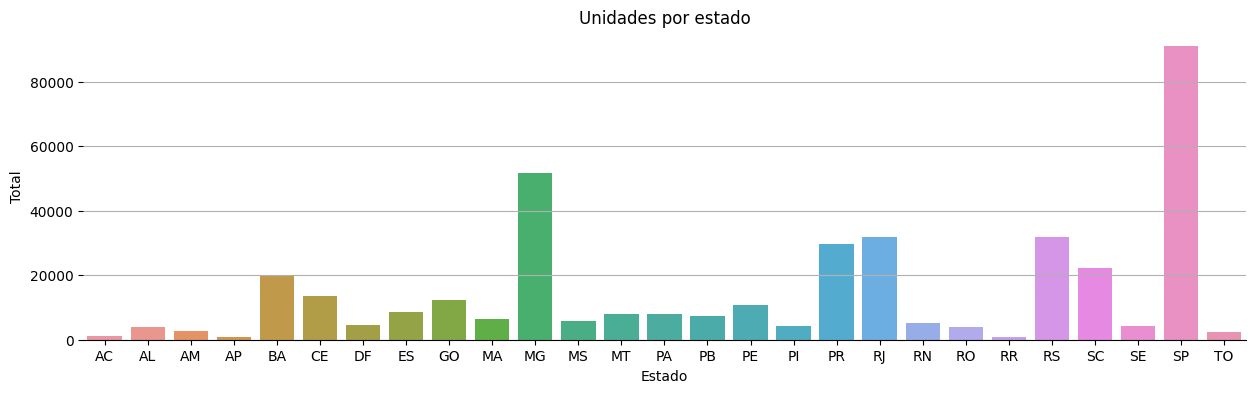

In [10]:
# Quantidade de unidades por estado
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(data=groupedDf.groupby('UF').Total.sum().reset_index(), x='UF', y='Total', ax=ax)
# Estética
ax.set(title='Unidades por estado', xlabel='Estado')
ax.yaxis.grid(True)
sns.despine(left=True)
plt.show()

## II. Heatmap: Quantidade e tipos de unidades por estado

A ideia dessa visualização é permitir uma visão geral e mais rápida de todos os dados relacionados a quantidade de instituições e suas respectivas regiões e tipos.

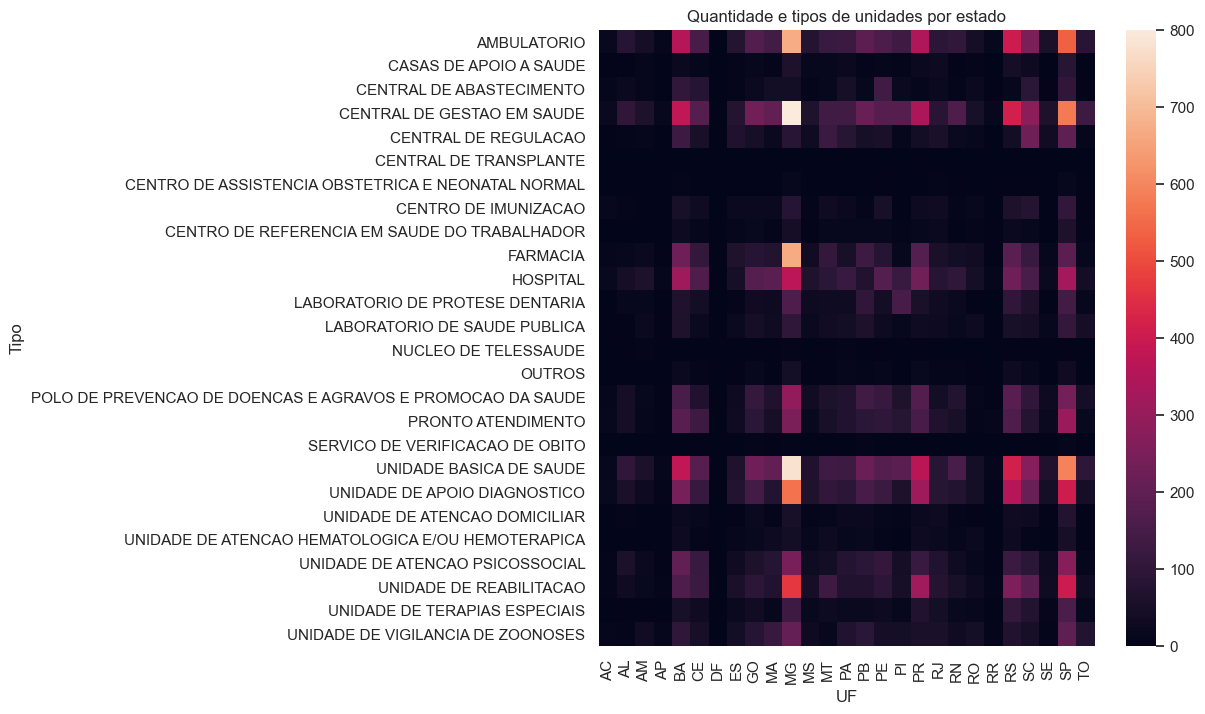

In [95]:
# Preparação dos dados
regDict = {"AC":"Norte", "AL": "Nordeste", "AM": "Norte", "AP": "Norte", "BA": "Nordeste", "CE": "Nordeste", 
           "DF":"Centro-Oeste", "ES": "Sudeste", "GO": "Centro-Oeste", "MA": "Nordeste", "MG": "Sudeste", 
           "MS":"Centro-Oeste", "MT": "Centro-Oeste", "PA":"Norte", "PB": "Nordeste", "PE": "Nordeste", 
           "PI": "Nordeste", "PR":"Sul", "RJ": "Sudeste", "RN": "Nordeste", "RO":"Norte", "RR": "Norte", 
           "RS": "Sul", "SC": "Sul", "SE":"Nordeste", "SP": "Sudeste", "TO": "Norte"}

temp = groupedDf.groupby(['Tipo','UF']).UF.agg(['count']).reset_index().rename(columns={'count': 'Unidades'})
temp = temp.pivot('Tipo', 'UF', 'Unidades').fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(temp, xticklabels=temp.columns, yticklabels=temp.index)
# Estética
ax.set(title=('Quantidade e tipos de unidades por estado'))
plt.show()


## III. Comparação por região

Esta abordagem busca facilitar a observação da quantidade de unidades por região

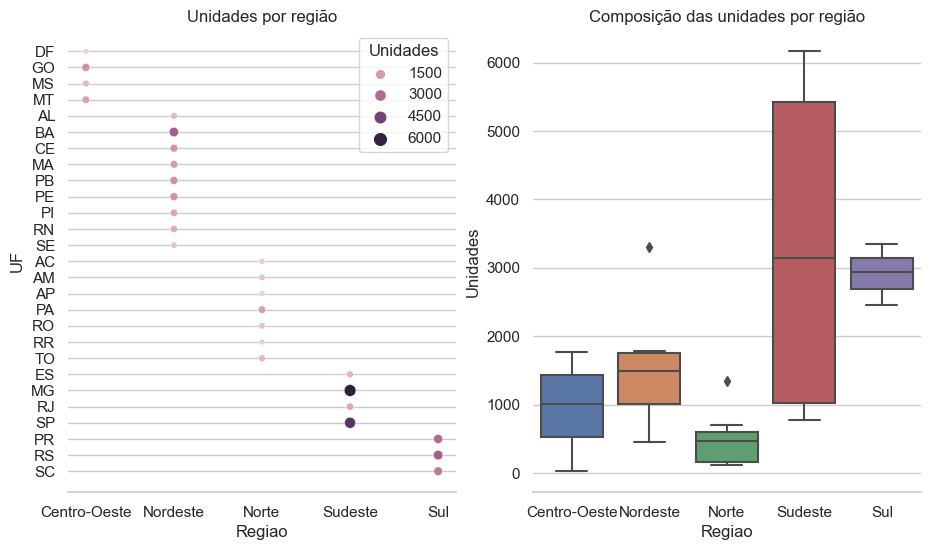

In [215]:
# Preparação dos dados
temp = pd.DataFrame(groupedDf['UF'].copy())
temp['Regiao'] = temp.UF.apply(lambda x: regDict[x])
temp = pd.DataFrame(temp.groupby(['Regiao', 'UF']).UF.agg(['count'])).reset_index().rename(columns={'count': 'Unidades'})

# Plot
fig, ax = plt.subplots(1,2, figsize=(11,6))
sns.scatterplot(data=temp, x='Regiao', y='UF', hue='Unidades', size='Unidades', legend='brief', ax=ax[0])
sns.boxplot(data=temp, x='Regiao', y='Unidades', ax=ax[1])

# Estética
ax[0].set(title=("Unidades por região"))
ax[0].xaxis.grid(False)
ax[1].set(title=('Composição das unidades por região'))

sns.despine(left=True)
sns.set_style("whitegrid")
plt.show()

## IV. Unidades desativadas

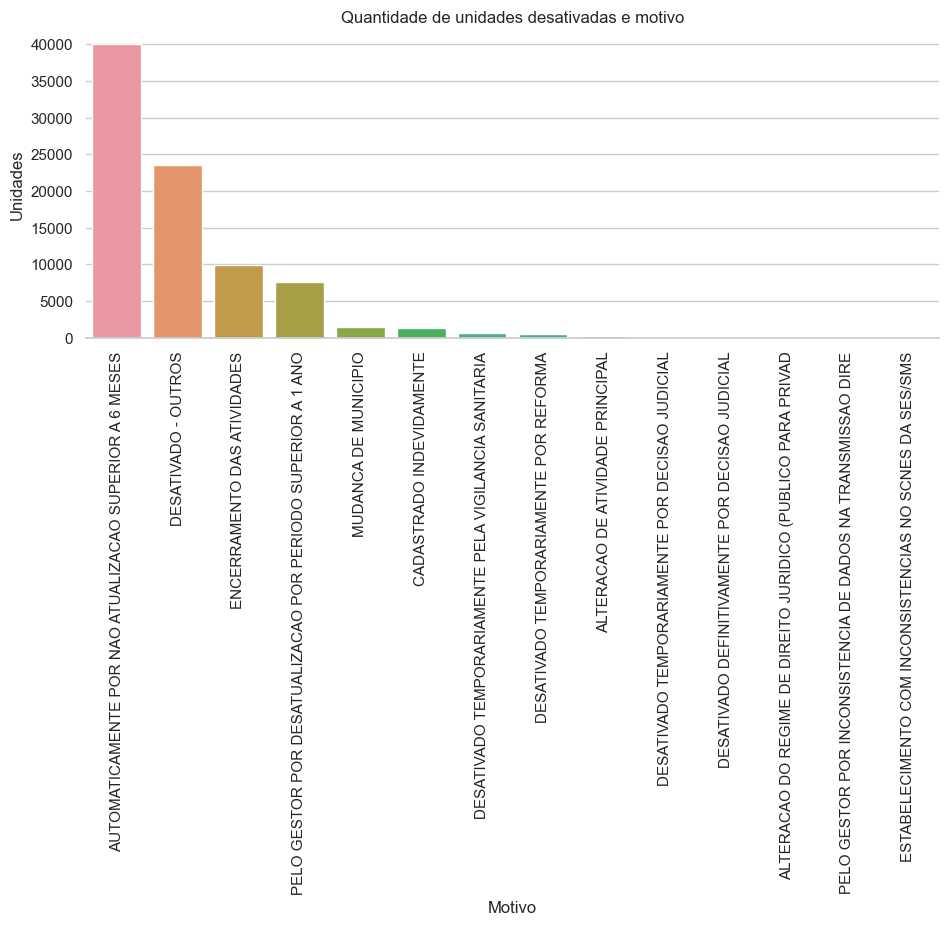

Quantidade de unidades ainda ativas: 354427


In [278]:
# Preparação dos dados
tCompDf = pd.DataFrame(db[dctKeys[2]].find({}, {'_id':0})).set_index('CD_MOTIVO_DESAB')
tCompDf.loc[0] = 'ATIVO'

temp = pd.DataFrame(base.CO_MOTIVO_DESAB.fillna(0).value_counts()).reset_index().rename(columns={'index':'Motivo', 'CO_MOTIVO_DESAB': 'Unidades'})
temp.Motivo = temp.Motivo.apply(lambda x: tCompDf.loc[x, 'DS_MOTIVO_DESAB'])

mask = temp.Motivo != 'ATIVO'

# Plot
fig, ax = plt.subplots(figsize=(11,4))
sns.barplot(data=temp[mask], x='Motivo', y='Unidades', ax=ax)
# Estética
ax.set_xticklabels(labels=temp[mask].Motivo, rotation=90)
ax.set(title=('Quantidade de unidades desativadas e motivo'))

sns.despine(left=True)
sns.set_style("whitegrid")
plt.show()
# Informação complementar
print(f'Quantidade de unidades ainda ativas: {temp[temp.Motivo == "ATIVO"].Unidades.values[0]}')